## Artificial Intelligence Assignment 2
## No9. Image Recognition
## 20132651 Sungjae Lee

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
import matplotlib.pyplot as plt
%matplotlib inline

# pytorch 를 이용하여 Image Recognition 을 진행하는 코드입니다. 
# 데이터셋은 손글씨 숫자 분류 데이터인 MNIST 가 사용됩니다.
# 이를 진행하기 위해 torch / torchvision / matplotlib 을 import 합니다.

In [2]:
is_cuda=False
if torch.cuda.is_available():
    is_cuda = True

# gpu 시스템인 cuda 의 사용 가능 여부를 체크하는 is_cuda 변수를 생성합니다.

In [3]:
transformation = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.1307,), (0.3081,))])

train_dataset = datasets.MNIST('data/',train=True,transform=transformation,download=True)
test_dataset = datasets.MNIST('data/',train=False,transform=transformation,download=True)

# MNIST 데이터를 서버에서 다운로드 받습니다. train 과 test 데이터를 따로 다운로드 받아
# data 폴더에 저장 후, train_dataset 과 test_dataset 변수에 저장합니다.
# 이 때, 이미지의 transform 설정은 위에서의 trasnformation 세팅대로 진행합니다.

In [4]:
train_loader = torch.utils.data.DataLoader(train_dataset,batch_size=32,shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset,batch_size=32,shuffle=True)

# batch 사이즈를 32로 하여 train 과 test 데이터를 loader 형태로 저장합니다.

In [5]:
sample_data = next(iter(train_loader))

# 샘플 데이터를 학습 데이터에서 추출하여 sample_data 변수에 저장합니다.

In [6]:
def plot_img(image):
    image = image.numpy()[0]
    mean = 0.1307
    std = 0.3081
    image = ((mean * image) + std)
    plt.imshow(image,cmap='gray')
    
# 이미지 데이터를 출력하는 함수, plot_img를 정의합니다.

### (1) 화면 출력 확인

tensor(7)


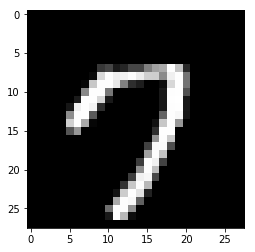

In [7]:
plot_img(sample_data[0][2])

# sample_data 에서 3번째 데이터를 뽑아 출력해 봅니다.
print(sample_data[1][2])
# 해당 데이터에 대한 label 출력하면, 이미지에 맞는 값이 나타납니다.

### (2) 화면 출력 확인

tensor(8)


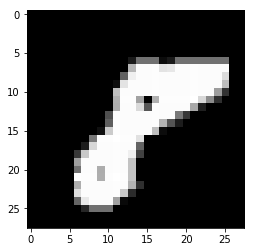

In [8]:
plot_img(sample_data[0][1])
print(sample_data[1][1])
# 이번에는 sample_data 에서 2번째 데이터를 뽑아 이미지와 레이블을 출력합니다.

In [9]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        #x = F.dropout(x,p=0.1, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)
    
# 이전의 TwoLayerNet 과 마찬가지로 구성하려는 신경망을 클래스 형태로 생성합니다.
# convolution 층 1, 2와 fully connected 층 1, 2가 존재하며, 
# conv2 에서는 dropout 이 진행되는 모습을 확인할 수 있습니다.
# conv1 과 2 모두 kernel size 를 5 * 5 로 진행하게 됩니다.

In [10]:
model = Net()
if is_cuda:
    model.cuda()

# 신경망을 model 변수에 생성하며, cuda 사용 여부에 따라 cuda() 메소드를 시행합니다.

In [11]:
optimizer = optim.SGD(model.parameters(), lr=0.01)

# 앞에서와 마찬가지로 SGD optimizer 를 사용하며, 이 때 학습률은 0.01 로 설정합니다.

In [12]:
data , target = next(iter(train_loader))

In [13]:
output = model(Variable(data))

# 최종적으로 model 을 통해 나오는 output 을 확인합니다.

### (3) output.size() 출력 확인

In [14]:
print(output.size())

torch.Size([32, 10])


### (4) target.size() 출력 확인

In [15]:
print(target.size())

torch.Size([32])


In [16]:
def fit(epoch, model, data_loader, phase = 'training', volatile = False):
    if phase == 'training':
        model.train()
    if phase == 'validation':
        model.eval()
        volatile = True
    running_loss = 0.0
    running_correct = 0
    for batch_idx, (data, target) in enumerate(data_loader):
        if is_cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data, volatile), Variable(target)
        if phase == 'training':
            optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        
        running_loss += F.nll_loss(output, target, size_average = False).data[0]
        preds = output.data.max(dim = 1, keepdim = True)[1]
        running_correct += preds.eq(target.data.view_as(preds)).cpu().sum()
        if phase == 'training':
            loss.backward()
            optimizer.step()
            
    loss = running_loss / len(data_loader.dataset)
    accuracy = 100. * float(running_correct)/len(data_loader.dataset)
    print(f'{phase} loss is {loss:{5}.{2}} and {phase} accuracy is {running_correct}/{len(data_loader.dataset)}{accuracy:{10}.{4}}')
    return loss, accuracy

# model 을 학습시키는 fit 함수를 정의합니다. 핵심 부분을 설명하면 다음과 같습니다.
# 먼저 training 과 validation 의 두 가지로 나누어지며, 이에 따라 train 혹은 eval 함수가 작동합니다.
# 한 번의 fit 은 한 번의 epoch 와 같으며, epoch 내에서 나누어진 batch 에 따라 학습이 진행됩니다.
# 진행중에 output 과 target 을 비교하여 loss 변수에 저장하며, 최종적으로 loss의 합을 평균냅니다.
# 이에 따른 loss 와 accuracy 를 출력하고, 해당 값을 반환하면 함수가 종료됩니다.

### (5) 화면 출력 확인

In [17]:
train_losses, train_accuracy = [], []
val_losses, val_accuracy = [], []
for epoch in range(1, 20):
    epoch_loss, epoch_accuracy = fit(epoch, model, train_loader, phase = 'training')
    val_ephoch_loss, val_epoch_accuracy = fit(epoch, model, test_loader, phase = 'validation')
    train_losses.append(epoch_loss)
    train_accuracy.append(epoch_accuracy)
    val_losses.append(val_ephoch_loss)
    val_accuracy.append(val_epoch_accuracy)
    
# 20회 epoch 로 학습을 진행합니다. 각 epoch 의 학습 결과는 training loss / validation loss
# train accuracy / validation accuracy 총 4가지로 나타나며, 각각의 값은 list 형태로 저장됩니다.

/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


training loss is  0.59 and training accuracy is 49064/60000     81.77
validation loss is  0.15 and validation accuracy is 9546/10000     95.46
training loss is  0.19 and training accuracy is 56783/60000     94.64
validation loss is 0.089 and validation accuracy is 9733/10000     97.33
training loss is  0.15 and training accuracy is 57429/60000     95.72
validation loss is 0.073 and validation accuracy is 9773/10000     97.73
training loss is  0.12 and training accuracy is 57841/60000      96.4
validation loss is 0.062 and validation accuracy is 9817/10000     98.17
training loss is  0.11 and training accuracy is 58024/60000     96.71
validation loss is 0.052 and validation accuracy is 9838/10000     98.38
training loss is   0.1 and training accuracy is 58208/60000     97.01
validation loss is 0.045 and validation accuracy is 9857/10000     98.57
training loss is 0.093 and training accuracy is 58325/60000     97.21
validation loss is 0.042 and validation accuracy is 9869/10000     98.69

### (6) 화면 출력 확인

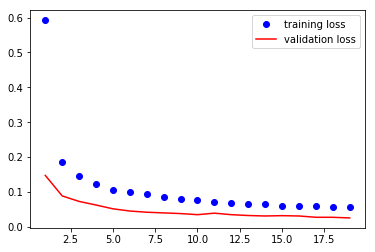

In [20]:
plt.plot(range(1,len(train_losses)+1),train_losses,'bo',label = 'training loss')
plt.plot(range(1,len(val_losses)+1),val_losses,'r',label = 'validation loss')
plt.legend()
plt.show()

# epoch 에 따른 train, validation loss 의 변화를 보여줍니다.
# 학습의 진행에 따라 loss 가 0에 가깝게 수렴해가는 점을 볼 수 있습니다.
# 학습 당시의 loss 에 비해 검증할 때의 loss 가 더 작은 값을 가지는 점을 확인할 수 있습니다.

### (7) 화면 출력 확인

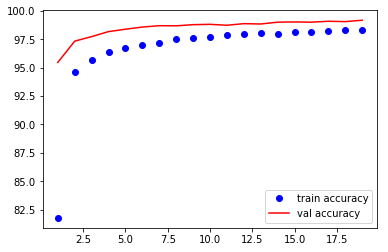

In [21]:
plt.plot(range(1, len(train_accuracy) + 1), train_accuracy, 'bo', label = 'train accuracy')
plt.plot(range(1, len(val_accuracy) + 1), val_accuracy, 'r', label = 'val accuracy')
plt.legend()
plt.show()

# epoch 에 따른 train, validation accuracy 의 변화를 보여줍니다.
# 학습의 진행에 따라 정답률인 accuracy 가 100에 가깝게 수렵해 가는 것을 볼 수 있습니다.
# loss 와 정 반대의 그래프로, 마찬가지로 검증의 accuracy 가 더 높게 나오는 점을 알 수 있습니다.